# Whirlpool Stock Time Series Analysis

In this notebook, we examine the performance of the Whirlpool Stock over time, devloping a few forecasting models and assessing their performance. Whirlpool was selected for the analysis, as through some research, I uncovered that historically their stock exhibits a monthly seasonal trend. Wanting to explore a time series analysis with a seasonal component, I selected Whirlppol for that reason.

Some notes:
    - stock data was trimmed to end 2019-01-01 to negate any influence of COVID on the stock maret for this elementary analysis
    - some code was adapted from https://github.com/Bounteous-Inc/Time-Series-Prediction/blob/master/Time%20Series%20Prediction%20Temp.ipynb
    

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from pmdarima.arima import auto_arima
import yfinance as yf
import datetime
from datetime import date, timedelta
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

Read in WHR stock data

In [2]:
start_date = pd.to_datetime('1999-01-01', format = '%Y-%m-%d')
end_date = pd.to_datetime('2019-01-01',  format = '%Y-%m-%d')
predict_date = pd.to_datetime('2017-02-01',  format = '%Y-%m-%d')

# Read in WHR stock data
df = yf.download('WHR', 
                 start=start_date, 
                 end=end_date, 
                 interval = '1mo',
                 progress=False
                ).dropna()
df = df[['Close', 'Volume']] # adjust data frame to only include the Close Price and Volume
close = pd.Series(df['Close'])
volume = pd.Series(df['Volume'])
df.head()

,Close,Volume
Date,,
1999-01-01,44.9375,7553900.0
1999-02-01,43.5000,7033500.0
1999-03-01,54.3750,12238200.0
1999-04-01,66.3750,12505100.0
1999-05-01,64.5000,7338100.0


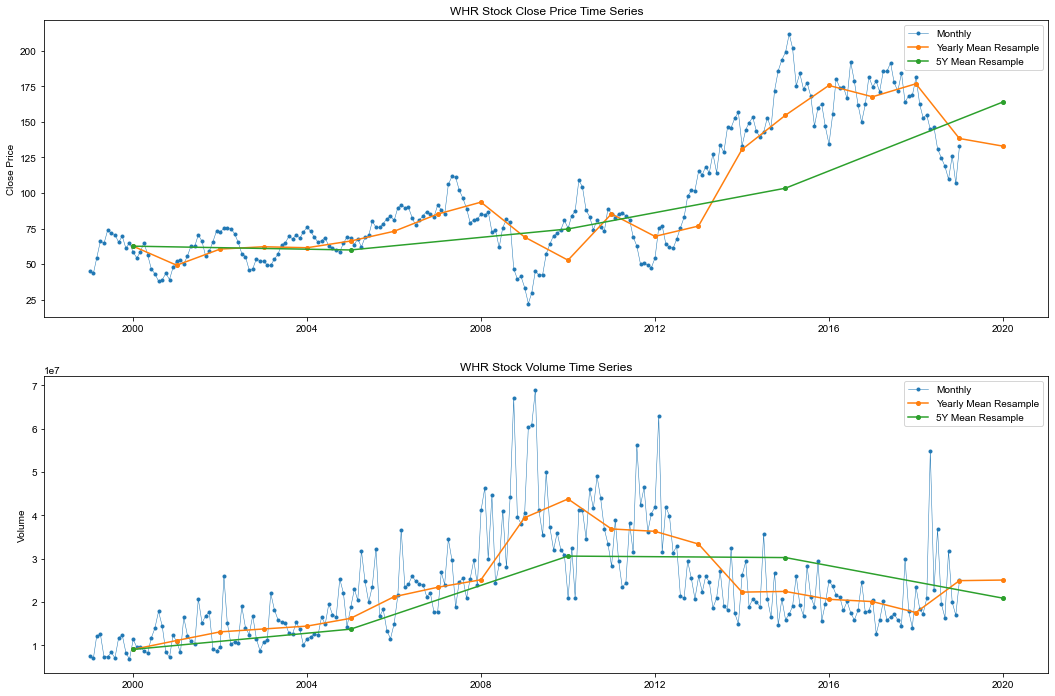

In [3]:
fig, ax = plt.subplots(2,1, figsize=(18,12))

ax1 = ax[0]
ax2 = ax[1]

ax1.plot(close,marker='.', linestyle='-', linewidth=0.5, label='Monthly')
ax1.plot(close.resample('Y').mean(),marker='o', markersize=4, label='Yearly Mean Resample')
ax1.plot(close.resample('5Y').mean(),marker='o', markersize=4, label='5Y Mean Resample')
ax1.set_title('WHR Stock Close Price Time Series')
ax1.set_ylabel('Close Price')
ax1.legend()

ax2.plot(volume,marker='.', linestyle='-', linewidth=0.5, label='Monthly')
ax2.plot(volume.resample('Y').mean(),marker='o', markersize=4, label='Yearly Mean Resample')
ax2.plot(volume.resample('5Y').mean(),marker='o', markersize=4, label='5Y Mean Resample')
ax2.set_title('WHR Stock Volume Time Series')
ax2.set_ylabel('Volume')
ax2.legend()

sns.set_theme()
plt.show()

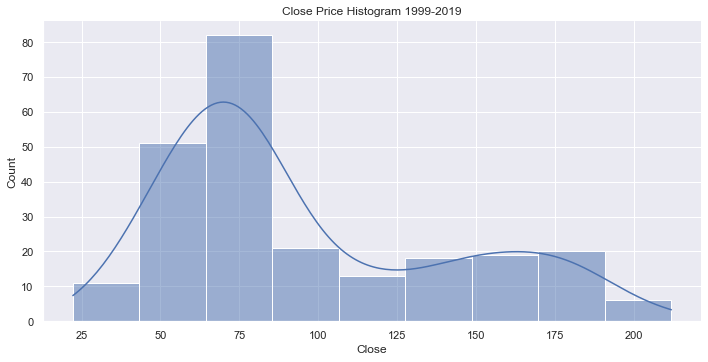

In [4]:
sns.displot(data=df[['Close']], x="Close", kde=True, aspect = 2).set(title = 'Close Price Histogram 1999-2019')
plt.show()

## Trend and Seasonality Analysis

A good place to start with understanding a time series is to decompose the data.

In [5]:
# function that decomposes a time series to examine trend and seasonality independently
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    decomposition.plot()
    plt.show()
    decomposition.seasonal.plot()
    plt.xlim(pd.to_datetime('2016-01-01', format = '%Y-%m-%d'), end_date)
    plt.show()


Through the decomposition of the Close price over time, a general upward trend is revealed (which was easy to visuallt identify), and we are able to extract a seasonal trend in the data by month. In the breakdown, it looks like close price is slightly above the trend in the spring, and tend to be below the trend expectation in the fall.

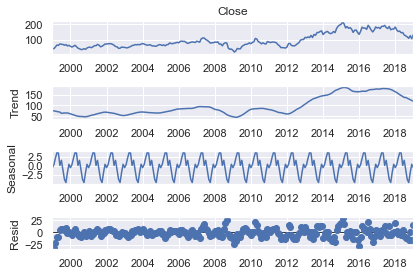

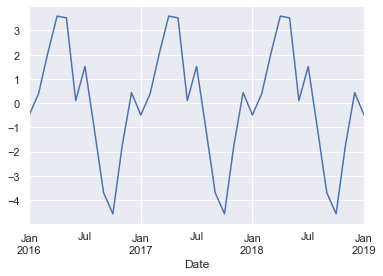

In [6]:
seasonal_decompose(close)

In order to properly analyze a time series, we need to check if the data is stationary. Data is stationary if statistical properties like mean, variance and autocorrelation are stagnant over time. Most raw data is not stationary, but in order to properly make predictions, we must manipulate that data to make it stationary through processes such as detrending and differencing.

In [7]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

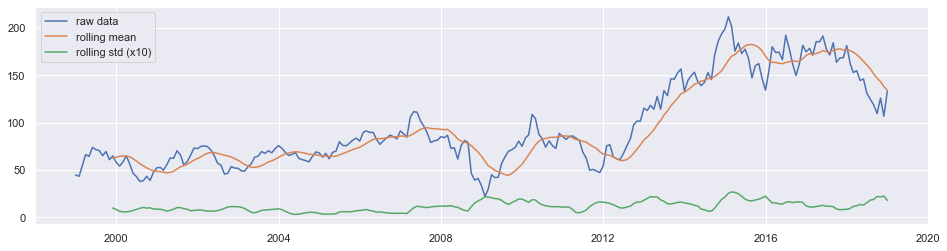

In [8]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(close,'raw data')

Based on the rolling mean and standard deviation plot, it appears that the data is not stationary, given that it the values for those statistical measure look to fluctuate over time. Next, we look at a few way to test is data is stationary. The ADF test examines whether the lagged values in a time series impact the value at a given time point, or whether the t-1 value provides relevent information for predicting the value at t. 

In [9]:
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [10]:
ADF_test(close,'raw data') # data not stationary

 > Is the raw data stationary ?
Test statistic = -1.248
P-value = 0.652
Critical values :
	1%: -3.4586084859607156 - The data is not stationary with 99% confidence
	5%: -2.873972159235721 - The data is not stationary with 95% confidence
	10%: -2.57339565928848 - The data is not stationary with 90% confidence


Now that we know the data is not stationary, we can examine ways to make the data stationary. Detrending removes the underlying trend in a data set.

 > Is the de-trended data stationary ?
Test statistic = -4.902
P-value = 0.000
Critical values :
	1%: -3.4592326027153493 - The data is  stationary with 99% confidence
	5%: -2.8742454699025872 - The data is  stationary with 95% confidence
	10%: -2.5735414688888465 - The data is  stationary with 90% confidence


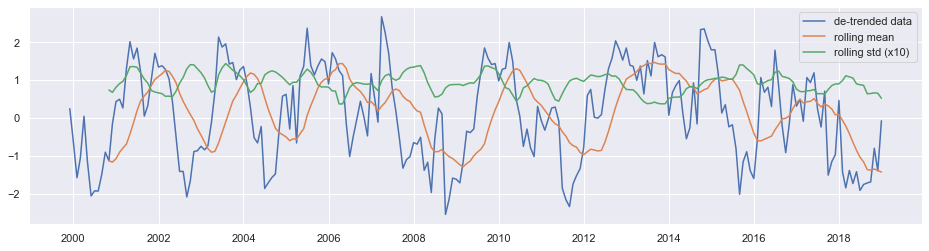

In [11]:
close_detrend = (df['Close'] - df['Close'].rolling(window=12).mean())/df['Close'].rolling(window=12).std()

# Data is made stationary by detrending
test_stationarity(close_detrend,'de-trended data')
ADF_test(close_detrend,'de-trended data')

Another way to make data stationary is through differencing which removes seasonal and cyclical patterns from a data set.

 > Is the 12 lag differenced data stationary ?
Test statistic = -3.133
P-value = 0.024
Critical values :
	1%: -3.4612821203214907 - The data is not stationary with 99% confidence
	5%: -2.875142613826617 - The data is  stationary with 95% confidence
	10%: -2.574020122281422 - The data is  stationary with 90% confidence


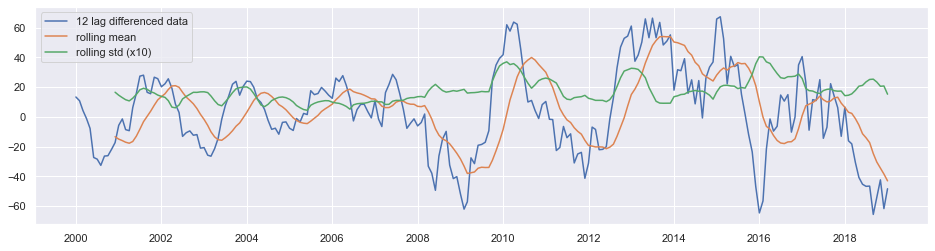

In [12]:
close_lag =  close - close.shift(12)

test_stationarity(close_lag,'12 lag differenced data')
ADF_test(close_lag,'12 lag differenced data')

# Modeling

Frist we enact a test-train-split on our data such that we can evaluate the performance of the models. we will use 1999-01 to 2017-01 as the training set and 2017-02 to 2019-01 as the testing set.

In [13]:
train = close[:predict_date] #train
test = close[predict_date:] #test  
predict_periods = len(close) - len(train)

First, we look at a very elementary forecasting method, simple exponential smoothing.

The Root Mean Squared Error of our forecasts with smoothing level of 0.1 is 29.25
The Root Mean Squared Error of our forecasts with smoothing level of 0.5 is 33.07


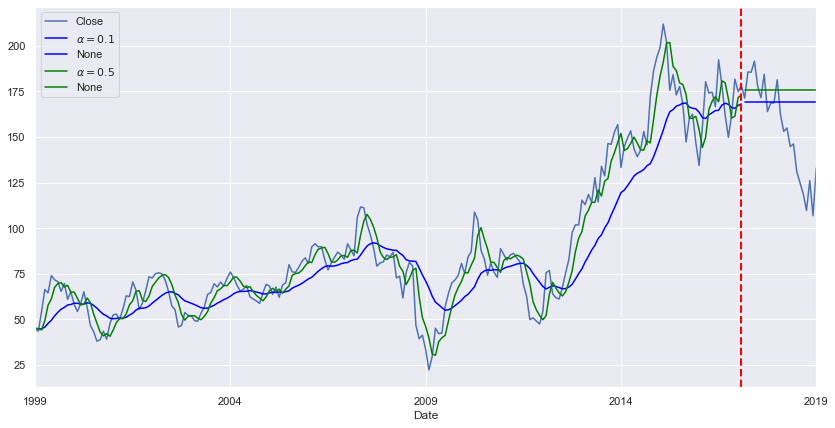

In [14]:
from statsmodels.tsa.api import SimpleExpSmoothing 

close.plot(legend=True, figsize=(14, 7))
    
fit1 = SimpleExpSmoothing(train).fit(smoothing_level=0.1,optimized=False)
fcast1 = fit1.forecast(predict_periods).rename(r'$\alpha={}$'.format(0.1))
    # specific smoothing level
fcast1.plot(color='blue', legend=True)
fit1.fittedvalues.plot(color='blue', legend = True)
mse1 = ((fcast1 - test) ** 2).mean()
print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(0.1,round(np.sqrt(mse1), 2)))
    
    
fit2 = SimpleExpSmoothing(train).fit(smoothing_level=0.5,optimized=False)
fcast2 = fit2.forecast(predict_periods).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
# plot
fcast2.plot(color='green', legend = True)
fit2.fittedvalues.plot(color='green', legend =True)
    
mse2 = ((fcast2 - test) ** 2).mean()
print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(0.5,round(np.sqrt(mse2), 2)))    

plt.axvline(x=predict_date, color = 'red', linestyle = '--', lw = 2)
plt.show()



The Root Mean Squared Error of Holts Linear trend 45.64
The Root Mean Squared Error of Holts Exponential trend 51.26


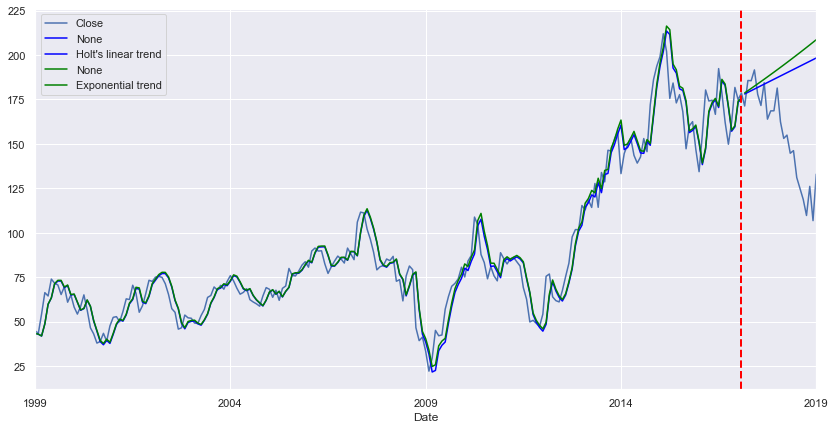

In [15]:
from statsmodels.tsa.api import Holt

close.plot(legend=True, figsize=(14, 7))
    
fit1 = Holt(train).fit(0.6, 0.1, optimized=False)
fcast1 = fit1.forecast(predict_periods).rename("Holt's linear trend")
mse1 = ((fcast1 - test) ** 2).mean()
print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))

fit2 = Holt(train, exponential=True).fit(0.6, 0.1, optimized=False)
fcast2 = fit2.forecast(predict_periods).rename("Exponential trend")
mse2 = ((fcast2 - test) ** 2).mean()
print('The Root Mean Squared Error of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    
fit1.fittedvalues.plot(color='blue', legend=True)
fcast1.plot(color='blue', legend=True)
fit2.fittedvalues.plot(color='green', legend=True)
fcast2.plot(color='green', legend=True)

plt.axvline(x=predict_date, color = 'red', linestyle = '--', lw = 2)

plt.show()

In [16]:
from statsmodels.tsa.api import ExponentialSmoothing

def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

The Root Mean Squared Error of additive trend, additive seasonal of period season_length=12 and a Box-Cox transformation 60.12
The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=12 and a Box-Cox transformation 39.22


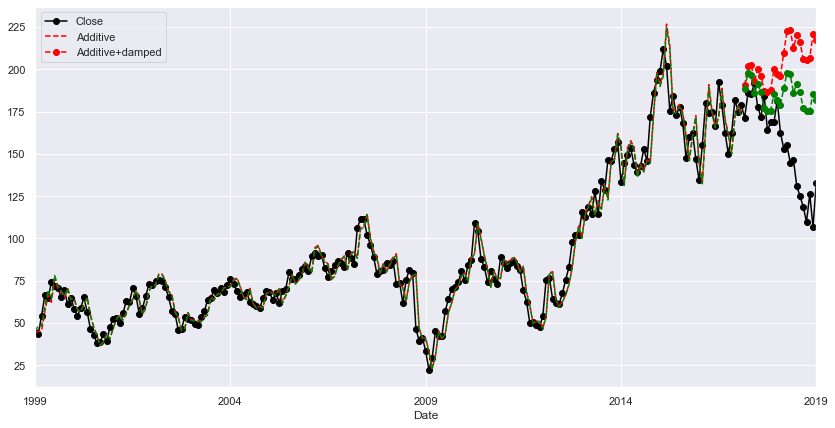

In [17]:
holt_win_sea(close, train, test, 'additive', 12, predict_periods)

In [18]:
from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, D=1, m=12, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=1521.723, Time=0.99 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1955.176, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1558.965, Time=0.24 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1765.113, Time=0.34 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1964.094, Time=0.01 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=1520.163, Time=0.63 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=1609.846, Time=0.31 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=1521.663, Time=2.03 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=1558.623, Time=0.67 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=1523.806, Time=2.91 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=1519.866, Time=0.43 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=1611.742, Time=0.24 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=1521.276, Time=0.58 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=1521.184, Time=1.10 sec
 ARIMA(1,0,2)(1,1,0

In [19]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = False 27.29


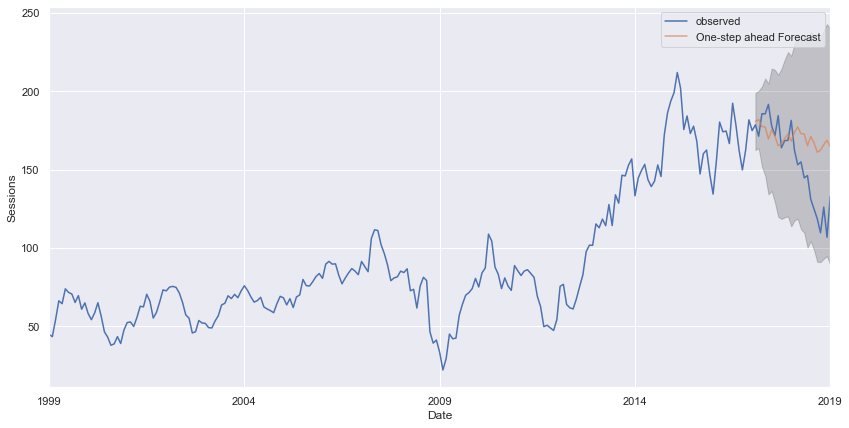

In [21]:
pred = results.get_prediction(start=pd.to_datetime('2017-02-01'), end=pd.to_datetime('2019-01-01'),  dynamic=False)
pred_ci = pred.conf_int()
y_forecasted = pred.predicted_mean
mse = ((y_forecasted - test) ** 2).mean()
print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(12,round(np.sqrt(mse), 2)))

ax = close.plot(label='observed')
y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sessions')
plt.legend()
plt.show()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9776      0.014     69.528      0.000       0.950       1.005
ma.S.L12      -0.8434      0.063    -13.344      0.000      -0.967      -0.720
sigma2        86.8037      7.213     12.035      0.000      72.667     100.940


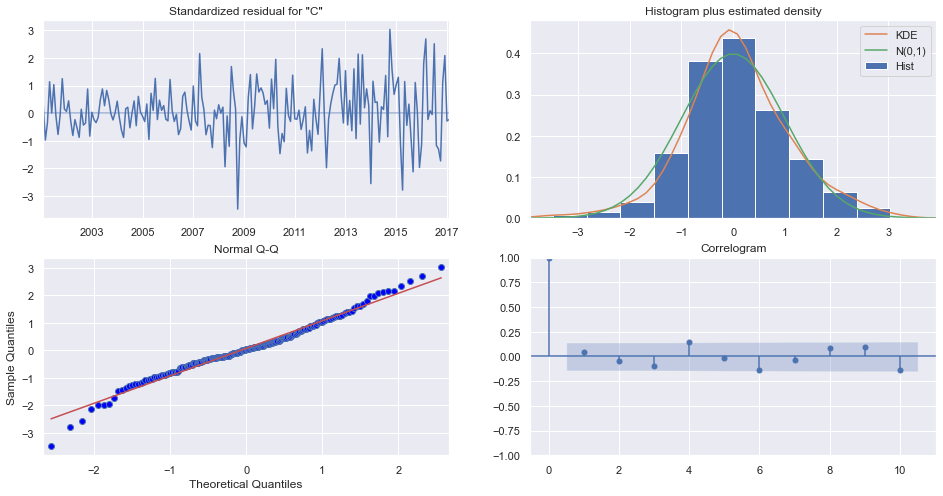

The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = False 2.15


TypeError: The DTypes <class 'numpy.dtype[float64]'> and <class 'numpy.dtype[datetime64]'> do not have a common DType. For example they cannot be stored in a single array unless the dtype is `object`.

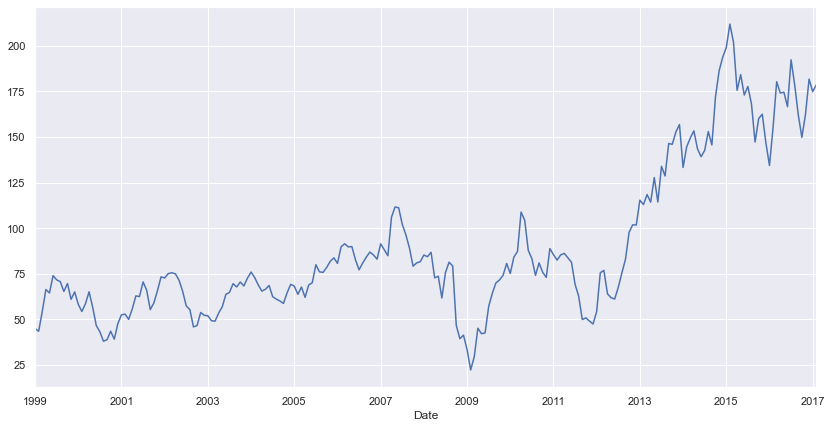

In [22]:
sarima_eva(train,(1,0,0),(0,1,1,12),12,'2017-02-01',test)